# Value at Risk - VaR

## Packages

In [25]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy.stats import norm
from scipy.stats import kurtosis, skew
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

## Create our Portfolio of Currencies

In [26]:
dolar_path = "https://ptax.bcb.gov.br/ptax_internet/consultaBoletim.do?method=gerarCSVFechamentoMoedaNoPeriodo&ChkMoeda=61&DATAINI=01/01/2000&DATAFIM=17/02/2023"
euro_path = "https://ptax.bcb.gov.br/ptax_internet/consultaBoletim.do?method=gerarCSVFechamentoMoedaNoPeriodo&ChkMoeda=222&DATAINI=01/01/2000&DATAFIM=17/02/2023"
libra_path = "https://ptax.bcb.gov.br/ptax_internet/consultaBoletim.do?method=gerarCSVFechamentoMoedaNoPeriodo&ChkMoeda=115&DATAINI=01/01/2000&DATAFIM=17/02/2023"
franco_path = "https://ptax.bcb.gov.br/ptax_internet/consultaBoletim.do?method=gerarCSVFechamentoMoedaNoPeriodo&ChkMoeda=97&DATAINI=01/01/2000&DATAFIM=17/02/2023"

## Set a Arbitrarily Investment Weights (Đặt trọng số tùy ý)

In [27]:
weights = np.array([0.25, 0.25,0.25,0.25])

## Initial Investment Amount

In [28]:
initial_investment = 10_000

## Dowloading Closing Prices

In [29]:
dolar = pd.read_csv(dolar_path, sep=';', decimal=',', engine='python',
                    names=['Data', 'Tipo1', 'Tipo2', 'MOEDA', 'PTAX_COMPRA', 'PTAX_VENDA', 'INVERSO1', 'INVERSO2'], usecols=['Data', 'PTAX_VENDA'])

euro = pd.read_csv(euro_path, sep=';', decimal=',', engine='python',
                   names=['Data', 'Tipo1', 'Tipo2', 'MOEDA', 'PTAX_COMPRA', 'PTAX_VENDA', 'INVERSO1', 'INVERSO2'], usecols=['Data', 'PTAX_VENDA'])

libra = pd.read_csv(libra_path, sep=';', decimal=',', engine='python',
                    names=['Data', 'Tipo1', 'Tipo2', 'MOEDA', 'PTAX_COMPRA', 'PTAX_VENDA', 'INVERSO1', 'INVERSO2'], usecols=['Data', 'PTAX_VENDA'])

franco = pd.read_csv(franco_path, sep=';', decimal=',', engine='python',
                 names=['Data', 'Tipo1','Tipo2','MOEDA','PTAX_COMPRA','PTAX_VENDA','INVERSO1','INVERSO2'],usecols=['Data','PTAX_VENDA'])

In [30]:
euro.head()

,Data,PTAX_VENDA
0,3012000,1.85047
1,4012000,1.89150
2,5012000,1.91582
3,6012000,1.90761
4,7012000,1.88241


In [31]:
euro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5812 entries, 0 to 5811
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Data        5812 non-null   int64  
 1   PTAX_VENDA  5812 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 90.9 KB


In [32]:
dolar.head()

,Data,PTAX_VENDA
0,3012000,1.8011
1,4012000,1.8337
2,5012000,1.8544
3,6012000,1.8461
4,7012000,1.8281


## Data Preparation

In [33]:
def arrmua_data(df):
    df['Date'] = df['Data'].apply(str)
    df['year'] = df['Date'].str[-4:].apply(int)
    df['month'] = df['Date'].str[-6:-4].apply(int)
    df['day'] = df['Date'].str[-8:-6].apply(int)
    df['Date'] = pd.to_datetime(df[['year','month','day']])

arrmua_data(dolar)
arrmua_data(euro)
arrmua_data(libra)
arrmua_data(franco)

euro['EUR'] = euro['PTAX_VENDA']
dolar['USD'] = dolar['PTAX_VENDA']
libra['GBP'] = libra['PTAX_VENDA']
franco['CHF'] = franco['PTAX_VENDA']

In [34]:
euro = euro[['Date', 'EUR']]
euro.set_index('Date', inplace=True)

dolar = dolar[['Date', 'USD']]
dolar.set_index('Date', inplace=True)

libra = libra[['Date', 'GBP']]
libra.set_index('Date', inplace=True)

franco = franco[['Date', 'CHF']]
franco.set_index('Date', inplace=True)

In [35]:
print("=" * 10 + 'EURO' + "=" * 10)
display(euro.head())

print("=" * 10 + 'USD' + "=" * 10)
display(dolar.head())

print("=" * 10 + 'GBP' + "=" * 10)
display(libra.head())

print("=" * 10 + 'CHF' + "=" * 10)
display(franco.head())

==========EURO==========


,EUR
Date,
2000-01-03,1.85047
2000-01-04,1.89150
2000-01-05,1.91582
2000-01-06,1.90761
2000-01-07,1.88241


==========USD==========


,USD
Date,
2000-01-03,1.8011
2000-01-04,1.8337
2000-01-05,1.8544
2000-01-06,1.8461
2000-01-07,1.8281


==========GBP==========


,GBP
Date,
2000-01-03,2.95132
2000-01-04,3.00455
2000-01-05,3.04904
2000-01-06,3.04721
2000-01-07,2.99885


==========CHF==========


,CHF
Date,
2000-01-03,1.15173
2000-01-04,1.17755
2000-01-05,1.19222
2000-01-06,1.18711
2000-01-07,1.16817


In [36]:
cesta = pd.concat([dolar, euro, libra, franco], axis=1)
cesta.head()

,USD,EUR,GBP,CHF
Date,,,,
2000-01-03,1.8011,1.85047,2.95132,1.15173
2000-01-04,1.8337,1.89150,3.00455,1.17755
2000-01-05,1.8544,1.91582,3.04904,1.19222
2000-01-06,1.8461,1.90761,3.04721,1.18711
2000-01-07,1.8281,1.88241,2.99885,1.16817


In [37]:
cesta_returns = np.log(1+cesta.pct_change(1)).dropna()
cesta_returns

,USD,EUR,GBP,CHF
Date,,,,
2000-01-04,0.017938,0.021931,0.017875,0.022171
2000-01-05,0.011225,0.012776,0.014699,0.012381
2000-01-06,-0.004486,-0.004295,-0.000600,-0.004295
2000-01-07,-0.009798,-0.013298,-0.015998,-0.016083
2000-01-10,-0.006586,-0.008820,-0.007377,-0.009513
...,...,...,...,...
2023-02-13,-0.013262,-0.009153,-0.008057,-0.010129
2023-02-14,-0.006329,-0.006608,-0.004763,-0.007633
2023-02-15,0.014188,0.010451,0.001436,0.010737


Kết quả của `cesta_returns` sẽ là một DataFrame mới chứa tỷ lệ phần trăm thay đổi logarit của giá trị cho mỗi cặp giá trị liền kề trong các cột `dolar`, `euro`, `libra` và `franco`.

 **Ý nghĩa:**

- `cesta_returns` cung cấp cho ta thông tin về mức độ biến động của tỷ giá hối đoái theo thời gian.

- Giá trị dương cho thấy giá trị tiền tệ đã tăng so với giá trị trước đó, trong khi giá trị âm cho thấy giá trị tiền tệ đã giảm.

- Việc sử dụng logarit tự nhiên giúp ổn định dữ liệu và dễ dàng so sánh mức độ biến động giữa các cột khác nhau.

<Axes: xlabel='Date'>

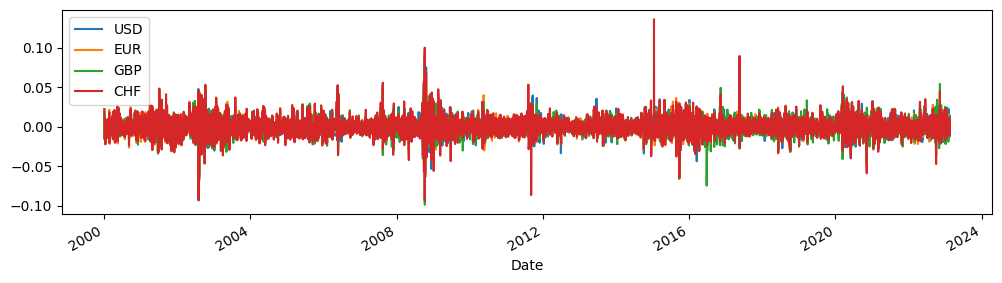

In [38]:
cesta_returns.plot(figsize=(12, 3))

## **1. Variance-Covariance Method (or Pametric)**

### Create a Covariance Matrix Based on Returns

In [39]:
# Generate Var-Cov Matrix
cov_matrix = cesta_returns.cov()
cov_matrix

,USD,EUR,GBP,CHF
USD,0.000093,0.000081,0.000080,0.000086
EUR,0.000081,0.000103,0.000089,0.000104
GBP,0.000080,0.000089,0.000101,0.000091
CHF,0.000086,0.000104,0.000091,0.000121


### Calculate the Portfolio Mean and Standard Deviation

In [40]:
# Calculate average return 
avg_returns = cesta_returns.mean()

# Calculate mean returns for portfolio overall
# using dot product to normalize individual means against investment weights
portfolio_mean = avg_returns.dot(weights)

# Portfolio Standard Deviation
portfolio_std = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

# Investment Mean
investment_mean = (1 + portfolio_mean) * initial_investment

# Standard Deviation of Investment
investment_std = portfolio_std * initial_investment

print("Portfolio mean is equal to", int(investment_mean), "and the standard deviation is equal to", round(investment_std, 2))

Portfolio mean is equal to 10001 and the standard deviation is equal to 96.14


### Inverse of the Normal Cumulative Distribution with a specified Confidence Interval, Standar Deviation and Mean

In [41]:
# Select your confidence interval

conf_level = 0.01

# Scipy ppf method to generate values for the
# inverse cumulative distribution function to a normal distribution
# plugging the mean, sd of our portfolio

cutoff = norm.ppf(conf_level, investment_mean,investment_std)
cutoff

9778.280141749377

### **Estimate the Value at Risk (VaR)**

In [43]:
# Calculate VaR
VaR_1day = initial_investment - cutoff

print("Value at Risk is equal to", int(VaR_1day),  "$, which is", round(VaR_1day/initial_investment*100,2), 'percent of initial investment')

Value at Risk is equal to 221 $, which is 2.22 percent of initial investment


**It means with 99% of confidence a 10k USD portfolio will not exceed losses greather than 219 USD over a one day period**

### Distribution

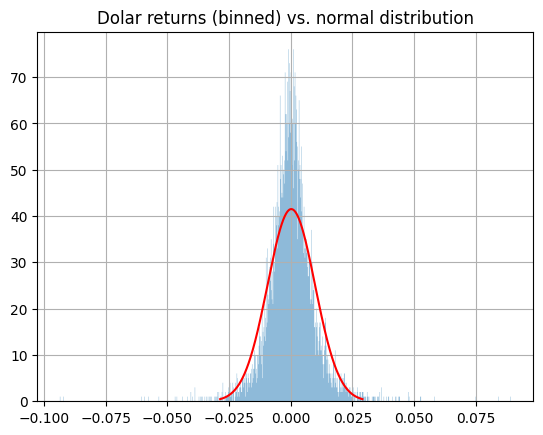

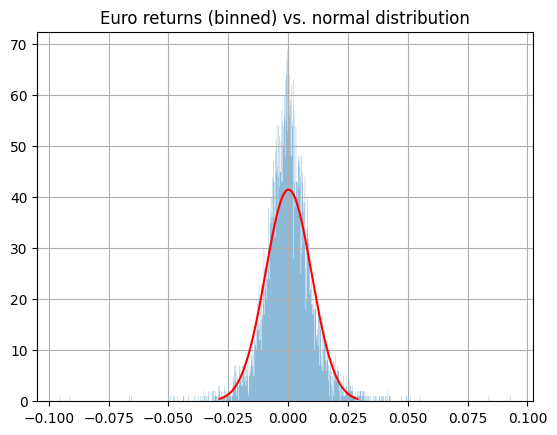

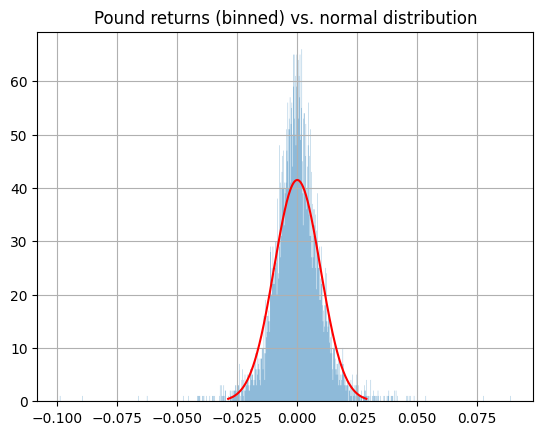

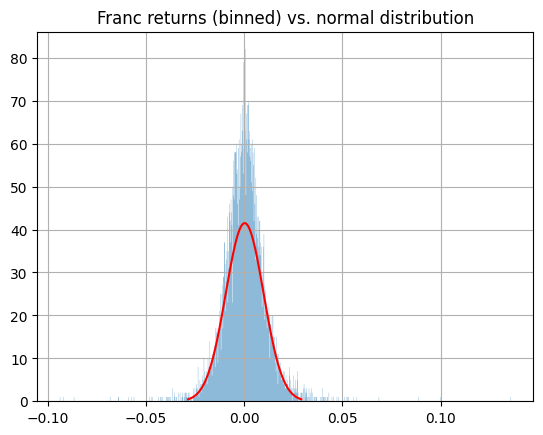

In [44]:
fxs = {'USD': 'Dolar', 'EUR': 'Euro', 'GBP' : 'Pound', 'CHF' : 'Franc'}

for fx in fxs:
    cesta_returns[fx].hist(bins = 1000, histtype = 'stepfilled', alpha = 0.5)
    x = np.linspace(portfolio_mean - 3*portfolio_std, portfolio_mean+3*portfolio_std,len(cesta_returns[fx]))
    plt.plot(x, norm.pdf(x, portfolio_mean, portfolio_std), "r")
    plt.title("{} returns (binned) vs. normal distribution".format(fxs[fx]))
    plt.show()

# **2. Historical Method**

In [47]:
# Convert Returns in to P&L (Profit and Loss)

PnL = (weights * cesta_returns.values).sum(axis = 1)
print(PnL.shape)
PnL

(5811,)


array([ 0.01997871,  0.01277027, -0.00341904, ...,  0.0092033 ,
        0.0036069 , -0.00906765])

In [49]:
historical_var_perc = np.percentile(PnL,1, interpolation='lower')
historical_var_perc

-0.024826427119132646

In [51]:
historical_var = historical_var_perc * initial_investment

print('The historical VaR is ', round(abs(historical_var), 1))

The historical VaR is  248.3


### Kurtosis and Skew

In [52]:
# A normal distribution should have a zero skew and more importantly,
# zero kurtosis (technically 3, but SciPy subtracts 3 to normalize it)
# So the distribution of our return does have fat tails
print(f"Skew is {round(skew(PnL),2)}")
print(f"Kurtosis is {round(kurtosis(PnL),2)}")

Skew is 0.05
Kurtosis is 8.52


### **Boostrap VaR**

In [53]:
def VaR99(data):
    return np.percentile(data, 1, interpolation= 'lower')

def boostrap(data, func):
    sample = np.random.choice(data, len(data))
    return func(sample)

def draw_bs_reps(data, func, size):
    """Draw bootsrap replicates"""
    bs_replicates = np.empty(size)

    for i in range(size):
        bs_replicates[i] = boostrap(data, func)
    return bs_replicates

In [54]:
boostrap_VaR_perc = draw_bs_reps(PnL, VaR99, 1000)

bs_VaR = abs(boostrap_VaR_perc) * initial_investment

print(f'The boostrap VaR is {round(np.mean(bs_VaR), 2)}')

C:\Users\Hải Nam\AppData\Local\Temp\ipykernel_17004\2600184631.py:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  return func(sample)


The boostrap VaR is 246.68


In [60]:
boostrap_VaR_perc

array([-0.02519929, -0.02500444, -0.02593637, -0.02533293, -0.02536802,
       -0.02592214, -0.02533293, -0.02610987, -0.02533293, -0.0239154 ,
       -0.02500444, -0.02536802, -0.02428295, -0.02325891, -0.02500444,
       -0.0220561 , -0.02533293, -0.02609819, -0.02549633, -0.02349518,
       -0.02593637, -0.02592214, -0.02482643, -0.02482643, -0.0239154 ,
       -0.02408049, -0.02454441, -0.0239154 , -0.02593637, -0.02259174,
       -0.02482643, -0.02325891, -0.02592214, -0.02533293, -0.02454441,
       -0.02428295, -0.02536802, -0.02251908, -0.02593637, -0.02500444,
       -0.02652255, -0.02548011, -0.02251769, -0.02500444, -0.02258287,
       -0.02652255, -0.02428295, -0.0239052 , -0.02536802, -0.02500444,
       -0.02325891, -0.02565249, -0.02408049, -0.02351849, -0.02428295,
       -0.02610987, -0.02295325, -0.02536802, -0.02593637, -0.02394705,
       -0.0239052 , -0.02592214, -0.0239154 , -0.02408049, -0.02389806,
       -0.02609819, -0.02549633, -0.02519929, -0.02548011, -0.02

In [61]:
bs_VaR

array([251.99291716, 250.0444006 , 259.36372452, 253.32925901,
       253.68017098, 259.22140474, 253.32925901, 261.09872377,
       253.32925901, 239.15400659, 250.0444006 , 253.68017098,
       242.82951216, 232.58914205, 250.0444006 , 220.56103041,
       253.32925901, 260.98193384, 254.96325578, 234.95181067,
       259.36372452, 259.22140474, 248.26427119, 248.26427119,
       239.15400659, 240.80489814, 245.44413888, 239.15400659,
       259.36372452, 225.91743608, 248.26427119, 232.58914205,
       259.22140474, 253.32925901, 245.44413888, 242.82951216,
       253.68017098, 225.1907649 , 259.36372452, 250.0444006 ,
       265.22547065, 254.80109333, 225.17691033, 250.0444006 ,
       225.82872211, 265.22547065, 242.82951216, 239.05200219,
       253.68017098, 250.0444006 , 232.58914205, 256.52493458,
       240.80489814, 235.1848799 , 242.82951216, 261.09872377,
       229.53250245, 253.68017098, 259.36372452, 239.47049758,
       239.05200219, 259.22140474, 239.15400659, 240.80

Text(0, 0.5, 'PDF')

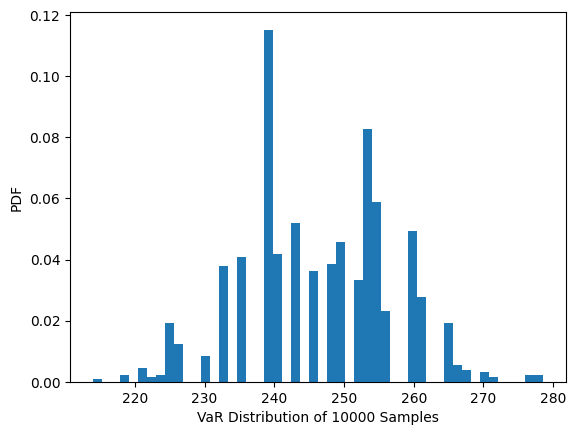

In [62]:
plt.hist(bs_VaR, bins=50, density=True)
plt.xlabel("VaR Distribution of 10000 Samples")
plt.ylabel("PDF")

### **Confidence Interval**

In [63]:
conf_intervals = np.percentile(bs_VaR, [1.0, 99.0])

print(f"The 99% Boostrap VaR confidence interval is {conf_intervals}")

The 99% Boostrap VaR confidence interval is [222.35559452 270.03897342]


## **3. Monte Carlo Simulation (Method)**

In [65]:
corr = cesta_returns.corr().values
chol = np.linalg.cholesky(corr)
corr

array([[1.        , 0.81975114, 0.81927087, 0.80475794],
       [0.81975114, 1.        , 0.87055726, 0.92459421],
       [0.81927087, 0.87055726, 1.        , 0.82422974],
       [0.80475794, 0.92459421, 0.82422974, 1.        ]])

In [66]:
chol

array([[1.        , 0.        , 0.        , 0.        ],
       [0.81975114, 0.57271989, 0.        , 0.        ],
       [0.81927087, 0.34739326, 0.45619421, 0.        ],
       [0.80475794, 0.46251749, 0.00929326, 0.37196217]])

In [67]:
usd_mean = cesta_returns['USD'].mean()
usd_sd = cesta_returns['USD'].std()

eur_mean = cesta_returns['EUR'].mean()
eur_sd = cesta_returns['EUR'].std()

gbp_mean = cesta_returns['GBP'].mean()
gbp_sd = cesta_returns['GBP'].std()

chf_mean = cesta_returns['CHF'].mean()
chf_sd = cesta_returns['CHF'].std()

In [68]:
var_list = []

for i in range(1000):

    usd_rets = np.random.normal(usd_mean, usd_sd, 1000)
    eur_rets = np.random.normal(eur_mean, eur_sd, 1000)
    gbp_rets = np.random.normal(gbp_mean, gbp_sd, 1000)
    chf_rets = np.random.normal(chf_mean, chf_sd, 1000)

    no_corr_port = np.array([usd_rets, eur_rets, gbp_rets, chf_rets])

    np.matmul(chol, no_corr_port)

    cesta_returns_sim = pd.DataFrame(np.matmul(chol, no_corr_port)).T

    # Generate Var-Cov Matrix
    cov_matrix = cesta_returns_sim.cov()
    cov_matrix

    # Calculate avarage return

    avg_returns = cesta_returns_sim.mean()

    # Calculate mean returns for portfolio overall, using dot product to normalize individual means against investment weights

    portfolio_mean = avg_returns.dot(weights)

    # Portfolio Standard Deviation

    portfolio_sd = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

    # Investment Mean

    investment_mean = (1+portfolio_mean) * initial_investment

    # SD of investment

    investment_sd = initial_investment * portfolio_sd

    # Select your confidence interval

    conf_level = 0.01

    # Scipy ppf method to generate values for the
    # inverse cumulative distribution function to a normal distribution
    # plugging the mean, sd of our portfolio

    cutoff = norm.ppf(conf_level, investment_mean, investment_sd)

    # Calculate VaR

    VaR_1day = initial_investment - cutoff

    var_list.append(VaR_1day)

In [69]:
np.mean(var_list)

210.44470450706135